Transfer learning is a research problem in machine learning that focuses on storing knowledge gained while solving one problem and applying it to a different but related problem. For example, knowledge gained while learning to recognize cars could apply when trying to recognize trucks.

In [ ]:

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models
import torch.optim as optim
import warnings

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time
warnings.filterwarnings('ignore')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
batch_size = 20
transformation_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
 

transformation_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# importing dataset
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Transfer learning/ants_and_bees-master/ants_and_bees-master/train', transform=transformation_train)
test_dataset  = datasets.ImageFolder(root='/content/drive/MyDrive/Transfer learning/ants_and_bees-master/ants_and_bees-master/val',  transform=transformation_test)
classes = ['ant', 'bee'] 

# constructing data loaders.
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

In [ ]:
train_iterator = iter(train_loader)
train_images, train_labels = train_iterator.next()
print( train_images.shape )
print( train_labels.shape )

torch.Size([20, 3, 224, 224])
torch.Size([20])


In [ ]:
# plots an image.
def convert_img(tensor_image):
    np_image = tensor_image.clone().detach().numpy()
    np_image = np_image.transpose(1, 2, 0)
    mean_3D = np.array((0.5, 0.5, 0.5))
    variance_3D = np.array((0.5, 0.5, 0.5))
    # denormalising image
    np_image = np_image * variance_3D + mean_3D
    np_image = np_image.clip(0, 1)
    return np_image

def convert_img_cuda(tensor_image):
    np_image = tensor_image.cpu().clone().detach().numpy()
    np_image = np_image.transpose(1, 2, 0)
    mean_3D = np.array((0.5, 0.5, 0.5))
    variance_3D = np.array((0.5, 0.5, 0.5))

    np_image = np_image * variance_3D + mean_3D
    np_image = np_image.clip(0, 1)
    return np_image

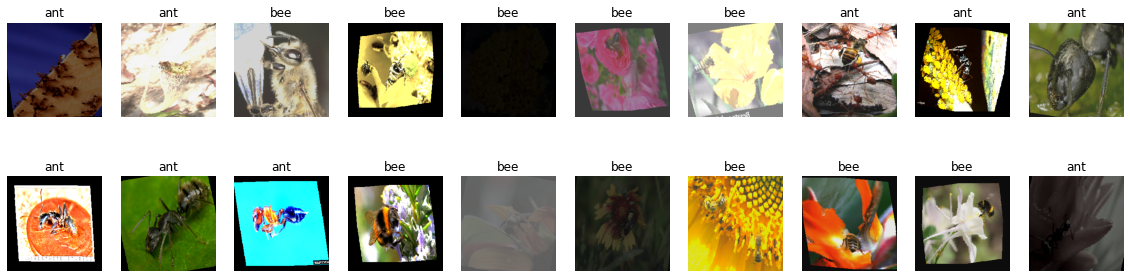

In [ ]:
figure = plt.figure(figsize=(20,8))    

for i in range(batch_size):
    axes = figure.add_subplot(3, 10, i+1)
    image = convert_img(train_images[i])
    title = classes[ train_labels[i] ]
    plt.imshow(image) 
    plt.title(title)
    plt.axis('off')

plt.show()

In [ ]:
alexNet_model = models.alexnet(pretrained=True)
print(alexNet_model)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


In [ ]:
for feature_extraction_layer in alexNet_model.features.parameters():
    feature_extraction_layer.requires_grad = False

last_layer_inputs = alexNet_model.classifier[6].in_features
last_layer = nn.Linear( last_layer_inputs, len(classes) )
alexNet_model.classifier[6] = last_layer
alexNet_model.to( device )

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(alexNet_model.parameters(), lr = 0.0001)

In [ ]:
numOfEpochs = 10
train_count = len(train_loader) * batch_size
test_count  = len(test_loader)  * batch_size
train_losses = []
test_losses  = []
train_acurracies = []
test_acurracies  = []

# training with the number of epochs.
for epoch in range(numOfEpochs):
    train_loss = 0.0
    test_loss = 0.0
    train_acc = 0.0
    test_acc = 0.0
  
    # training the model with the train dataset.
    for train_images, train_labels in train_loader:
    
        # registering train images and labels 
        # to device to benefit from GPU
        train_images = train_images.to( device )
        train_labels = train_labels.to( device )
        # calculating loss for training
        # dataset for the current batch.
        train_labels_head = alexNet_model.forward(train_images)
        loss = criterion(train_labels_head, train_labels)
    
        # updating weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()  
    
        # calculating acurracy for the current
        # batch for the training dataset.
        predictions = torch.max( train_labels_head , 1)[1] 
        acurracy = torch.sum( predictions == train_labels )
    
        # summing training acurracy and 
        # loss wit the remaining batches.
        train_acc += acurracy 
        train_loss += loss.item()
    
    print("EPOCH --> " + str(epoch + 1))
    print("----------------------------------------------")
  
    # testing the current model within the current epoch.
    for test_images, test_labels in test_loader:
    
        # registering test images and labels 
        # to device to benefit from GPU
        test_images = test_images.to( device )
        test_labels = test_labels.to( device )
    
        # calculating loss for test 
        # dataset for the current batch.
        test_labels_head = alexNet_model.forward(test_images)
        loss = criterion(test_labels_head, test_labels)
    
        # calculating acurracy for the cur-
        # rent batch for the test dataset.
        predictions = torch.max( test_labels_head , 1)[1] 
        acurracy = torch.sum( predictions == test_labels )
    
        # summing test acurracy and 
        # loss wit the remaining batches.
        test_acc += acurracy 
        test_loss += loss.item()
 
    # printing out the training dataset 
    # results for the current batch.
    train_acc = float(train_acc.float()) / train_count
    train_acurracies.append( train_acc )
    print("Train Acurracy: " + str( float(train_acc) ))
    
    train_loss = train_loss / train_count
    train_losses.append( train_loss )
    print("Train Loss: " + str(train_loss) + "\n")
  
    # printing out the test dataset 
    # results for the current batch.
    test_acc = float(test_acc.float()) / test_count
    test_acurracies.append( test_acc )
    print("Test Acurracy: " + str( float(test_acc) ))    
    
    test_loss = test_loss / test_count
    test_losses.append( test_loss )
    print("Test Loss: " + str(test_loss))
    print("----------------------------------------------\n")

EPOCH --> 1
----------------------------------------------
Train Acurracy: 0.5884615384615385
Train Loss: 0.032717962677662187

Test Acurracy: 0.825
Test Loss: 0.019488643482327463
----------------------------------------------

EPOCH --> 2
----------------------------------------------
Train Acurracy: 0.6846153846153846
Train Loss: 0.02865039362357213

Test Acurracy: 0.8
Test Loss: 0.017713358765468
----------------------------------------------

EPOCH --> 3
----------------------------------------------
Train Acurracy: 0.7076923076923077
Train Loss: 0.023239093961623998

Test Acurracy: 0.825
Test Loss: 0.01650208914652467
----------------------------------------------

EPOCH --> 4
----------------------------------------------
Train Acurracy: 0.7423076923076923
Train Loss: 0.019343793105620604

Test Acurracy: 0.81875
Test Loss: 0.017492207745090128
----------------------------------------------

EPOCH --> 5
----------------------------------------------
Train Acurracy: 0.796153846153

In [ ]:
test_iterator = iter(test_loader)
test_images, test_labels = test_iterator.next()
test_labels = test_labels.to( device )
test_images = test_images.to( device )
test_predict = alexNet_model.forward(test_images)
test_predict = torch.max( test_predict , 1)[1] 
print( test_images.shape )
print( test_labels.shape )
print( test_predict.shape )

torch.Size([20, 3, 224, 224])
torch.Size([20])
torch.Size([20])


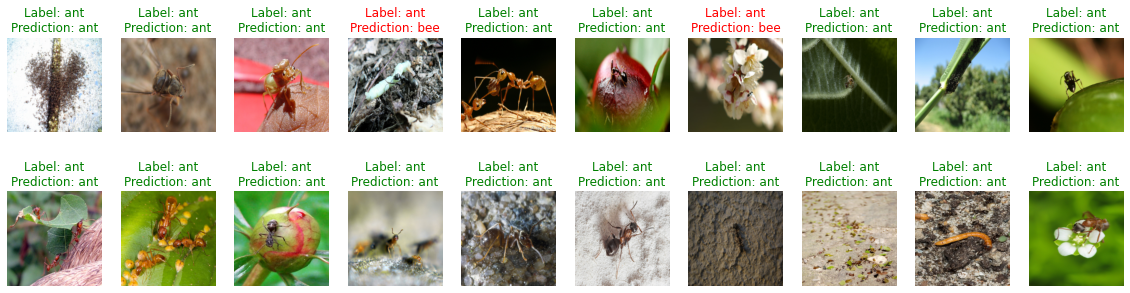

In [ ]:
figure = plt.figure(figsize=(20,8))    

for i in range(batch_size):
    axes = figure.add_subplot(3, 10, i+1)
    image = convert_img_cuda(test_images[i])
    title = "Label: " + str( classes[ test_labels[i] ] ) + "\n" + "Prediction: " + str(classes[ test_predict[i] ]) 
    plt.imshow(image) 
    plt.axis('off')
    if( str( classes[ test_labels[i] ] ) == str(classes[ test_predict[i] ] )):
        plt.title(title, color="green")
    else:
        plt.title(title, color="red")

plt.show()

In [ ]:
acurracy = torch.sum( test_predict == test_labels )
print( float( acurracy) / batch_size  )

0.9


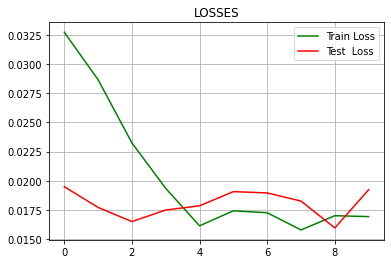

In [ ]:
# plotting loss graph.
plt.title("LOSSES")
plt.plot(train_losses, label = "Train Loss", color= "green")
plt.plot(test_losses,  label = "Test  Loss", color= "red")
plt.legend()
plt.grid()

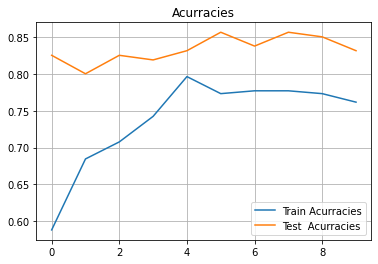

In [ ]:
plt.title("Acurracies")
plt.plot(train_acurracies, label = "Train Acurracies")
plt.plot(test_acurracies,  label = "Test  Acurracies")
plt.legend()
plt.grid()

In [ ]:
#Defining function for confusion matrix plot
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#Print Confusion matrix
    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=5)

In [ ]:
#Making prediction
y_pred = test_predict
y_true = test_labels

Confusion matrix, without normalization


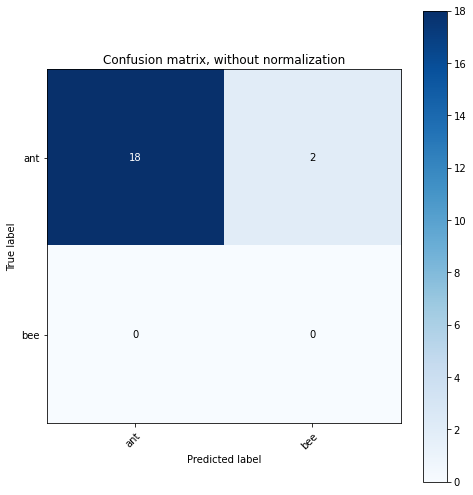

In [ ]:
#Plotting the confusion matrix
confusion_mtx = confusion_matrix(y_true,y_pred)

class_names=['ant','bee']

# Plotting non-normalized confusion matrix
plot_confusion_matrix(y_true, y_pred, classes = class_names,title = 'Confusion matrix, without normalization')